In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
import os, sys, h5py, cv2, warnings

from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from matplotlib import pyplot as plt
from dotenv import load_dotenv
from tensorflow import keras

load_dotenv()

sys.path.append("../")

sns.color_palette('colorblind')
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

try:
    pc_dpi = int(os.getenv('DPI'))
except TypeError:
    pc_dpi = 100
if pc_dpi is None:
    pc_dpi = 100


tf.get_logger().setLevel("ERROR")

# Executed on Kaggle with GPU acceleration, read only (or markdown edit)


# 1 : Loading the data :

- Data is stored in a h5 file and already splitted in train/test sets with balanced classes
- Classes names are str stored as bytes so we need to decode those
- Checking images against their label to double check

In [2]:
h5_filepath = "/kaggle/input/images-h5/product_images.h5"

with h5py.File(h5_filepath, "r") as h5file:
    X_train = h5file["images_train"][:]
    y_train_coded = h5file["category_train"][:]
    X_test = h5file["images_test"][:]
    y_test_coded = h5file["category_test"][:]


In [3]:
# Decoding the categories because of h5 storage : 
y_train = [y.decode() for y in y_train_coded]
y_test = [y.decode() for y in y_test_coded]


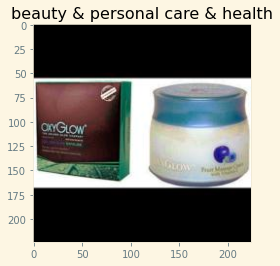

In [4]:
# Testing images from both sets, checking category :

plt.imshow(X_train[5])
plt.title(f"{y_train[5]}")
plt.grid(None)


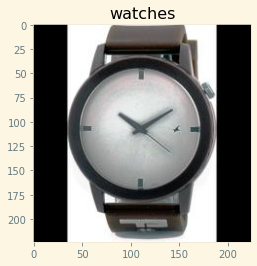

In [5]:
# Testing images from both sets :

plt.imshow(X_test[0])
plt.title(f"{y_test[0]}")
plt.grid(None)


# 2 : Using VGG16 + fine tuning
- Include_top=False -> VGG16 as feature extractor
- Disabling training on vgg16 layers
- Encoding the labels, first as ints then with keras' OHE
- Building new model with :
    - VGG16
    - A flatten layer to go from 3D(rgb) to 1D
    - Dense layer with 256 neurons
    - 20% dropout
    - Dense layer with 124 neurons
    - 20% dropout
    - Output layer with len(unique_classes)

In [6]:
# Images are 224 by 224 rgb -> 3 channels
# We want to fine tune the vgg16 model

height = 224
width = 224
channels = 3

vgg16 = keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(height, width, channels)
    )

# Freezing the not trainable layers :
vgg16.trainable = False


2023-01-02 15:42:51.745007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 15:42:51.755013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 15:42:51.755744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 15:42:51.756888: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
number_classes = len(set(y_train))  # len of unique items in list, i.e. number of classes

le = LabelEncoder()  # Encoding as int for compatibility

y_train_le = le.fit_transform(y=y_train)
y_test_le = le.transform(y=y_test)

# Using keras one hot encoder, will use numpy argmax for most likely prediction
y_train_ohe = keras.utils.to_categorical(y_train_le, num_classes=number_classes)
y_test_ohe = keras.utils.to_categorical(y_test_le, num_classes=number_classes)


In [8]:
# Let's build a model on top of VGG16 :

flatten_layer = keras.layers.Flatten()  # From 3D (RGB) to 1D
first_dense_layer = keras.layers.Dense(256, activation="relu")
second_dense_layer = keras.layers.Dense(128, activation="relu")
twenty_percent_dropout_layer = keras.layers.Dropout(rate=0.3)
prediction_layer = keras.layers.Dense(number_classes, activation="softmax")

classification_model = keras.models.Sequential([
    vgg16,
    flatten_layer,
    first_dense_layer,
    twenty_percent_dropout_layer,
    second_dense_layer,
    twenty_percent_dropout_layer,
    prediction_layer
    ]
)


In [9]:
classification_model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

classification_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 903       
Total params: 21,171,271
Trainable params: 6,456,583
Non-trainable params: 14,714,688
____________________________________

# 3 : Fitting and training the model
- Converting X_train and X_test to tensors expected by VGG16 using `keras.applications.vgg16.preprocess_input`
- Training the model for 30 epochs (dropout is a bit high to avoid overfitting)
- Batch size = 32 : faster runs and avoiding overfitting
- Plotting loss and accuracy variables

In [10]:
# Using keras's vgg16 preprocessor to convert the images' arrays to the expected format

X_train_preprocessed = keras.applications.vgg16.preprocess_input(X_train)
X_test_preprocessed = keras.applications.vgg16.preprocess_input(X_test)


In [11]:
history = classification_model.fit(
    X_train_preprocessed,
    y_train_ohe,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_preprocessed, y_test_ohe)
)


2023-01-02 15:42:54.792353: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-01-02 15:42:55.745577: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


23/23 [==============================] - 11s 274ms/step - loss: 13.7202 - accuracy: 0.4637 - val_loss: 2.9324 - val_accuracy: 0.7662
Epoch 2/30
23/23 [==============================] - 2s 94ms/step - loss: 5.3862 - accuracy: 0.7095 - val_loss: 2.7930 - val_accuracy: 0.7695
Epoch 3/30
23/23 [==============================] - 2s 93ms/step - loss: 3.6845 - accuracy: 0.8115 - val_loss: 3.1143 - val_accuracy: 0.8182
Epoch 4/30
23/23 [==============================] - 2s 94ms/step - loss: 3.4687 - accuracy: 0.8254 - val_loss: 3.4178 - val_accuracy: 0.8182
Epoch 5/30
23/23 [==============================] - 2s 92ms/step - loss: 1.9466 - accuracy: 0.8757 - val_loss: 3.1385 - val_accuracy: 0.7727
Epoch 6/30
23/23 [==============================] - 2s 93ms/step - loss: 2.1099 - accuracy: 0.8869 - val_loss: 3.6548 - val_accuracy: 0.7857
Epoch 7/30
23/23 [==============================] - 2s 94ms/step - loss: 1.5394 - accuracy: 0.8980 - val_loss: 3.1912 - val_accuracy: 0.8247
Epoch 8/30
23/23 [===

In [12]:
# Checking keys
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

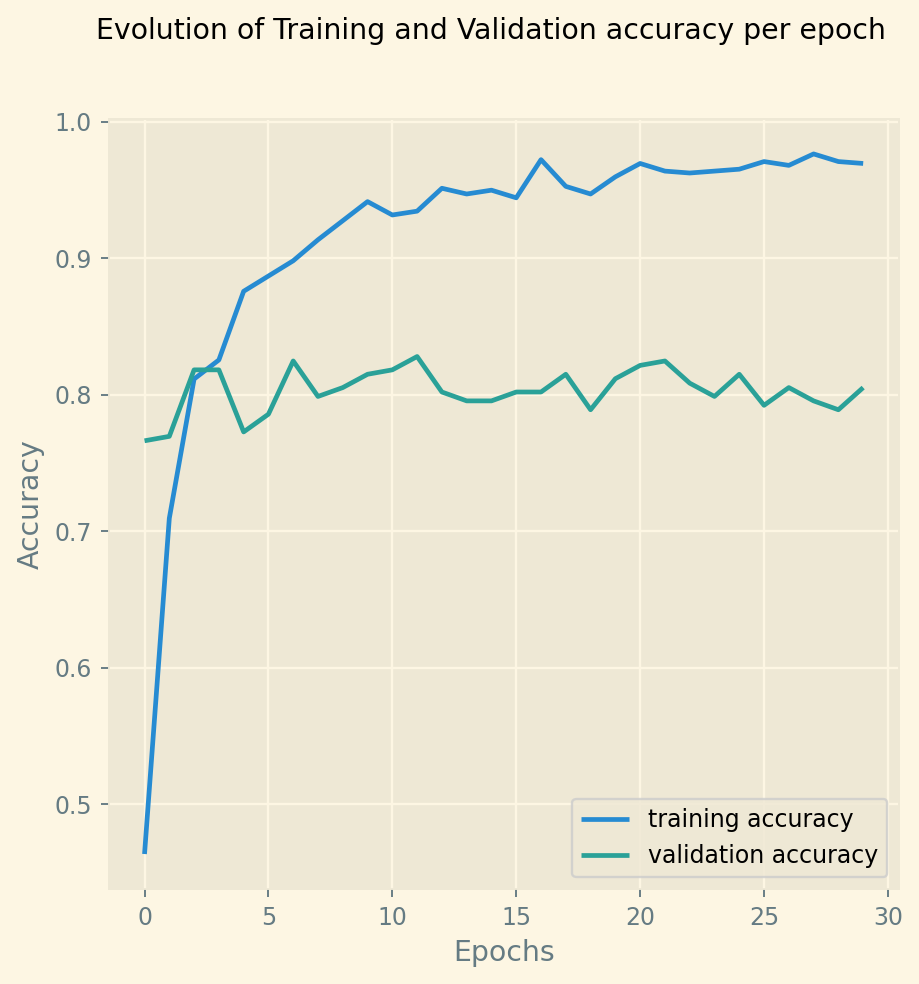

In [13]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(6, 6),
    dpi=170,
)

training_accuracy = history.history["accuracy"]
validation_accuracy = history.history["val_accuracy"]

ax1.plot(training_accuracy, label="training accuracy")
ax1.plot(validation_accuracy, label="validation accuracy")

###
# Titles/Lables
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
fig.suptitle("Evolution of Training and Validation accuracy per epoch")
#
###

plt.show()


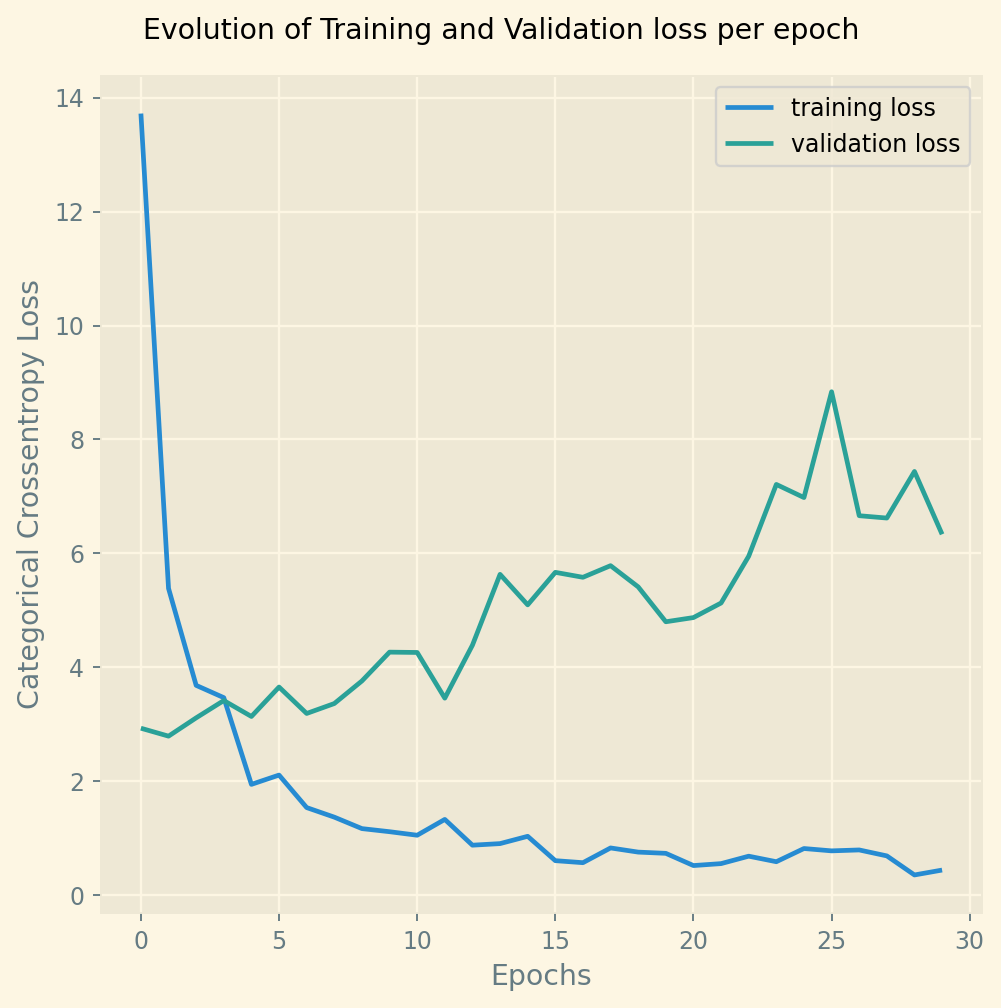

In [14]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(6, 6),
    dpi=170,
)

training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]

ax1.plot(training_loss, label="training loss")
ax1.plot(validation_loss, label="validation loss")

###
# Titles/Lables
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Categorical Crossentropy Loss")
fig.suptitle("Evolution of Training and Validation loss per epoch")
#
###

fig.tight_layout()
plt.show()


In [15]:
classification_model.evaluate(X_test_preprocessed, y_test_ohe)


10/10 [==============================] - 1s 64ms/step - loss: 6.3358 - accuracy: 0.8052


[6.335808277130127, 0.8051947951316833]

# 4 : Using the classifier on test data
- Predicting on X_test
- Using numpy's argmax function to get the highest value from expected one hot encoded array of probabilities


In [16]:
y_predict_ohe = classification_model.predict(X_test_preprocessed)

y_predict = np.argmax(y_predict_ohe, axis=1)


In [17]:
cnn_accuracy = accuracy_score(y_true=y_test_le, y_pred=y_predict)

print(cnn_accuracy)


0.8051948051948052


In [18]:
inv_y_predict = le.inverse_transform(y_predict)
inv_true = le.inverse_transform(y_test_le)

# This reverses the encoding on labels
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print(classification_report(y_true=inv_true, y_pred=inv_y_predict))


                                 precision    recall  f1-score   support

                      baby care       0.84      0.60      0.70        45
beauty & personal care & health       0.81      0.87      0.84        45
     home decor & festive needs       0.71      0.67      0.69        45
                home furnishing       0.73      0.89      0.80        45
               kitchen & dining       0.76      0.91      0.83        45
                     multimedia       0.84      0.82      0.83        38
                        watches       1.00      0.89      0.94        45

                       accuracy                           0.81       308
                      macro avg       0.81      0.81      0.80       308
                   weighted avg       0.81      0.81      0.80       308



### Observation :

- It seems the model overfits the training data quite quickly. Training it on 5-10 epochs would be preferable. Other than that the model performs quite well, the fact that it is pretrained on imagenet allows it to perform well very quickly.
- F1 score in average (+ precision and recall) are overall high at arount 0.82. The model performs well on "watches" and "beauty and personnal care" and not very well in classes like "home decor" and "home furnishing". This can be explained by the fact that watches show very distinct and common features (hands, dials, shape), like "beauty and personnal care" (product + packaging on white background for example). Classes relative to home decor and furnishing are likely misidentified because the photos of the items usually displays those as a part of a whole setting (pictures are often taken in their context, opposite of watches and beauty products).


In [19]:
# Confusion matrix :

conf_matrix = pd.DataFrame(confusion_matrix(y_true=inv_true, y_pred=inv_y_predict))
conf_matrix.columns = le.inverse_transform(conf_matrix.columns)
conf_matrix.index = le.inverse_transform(conf_matrix.index)


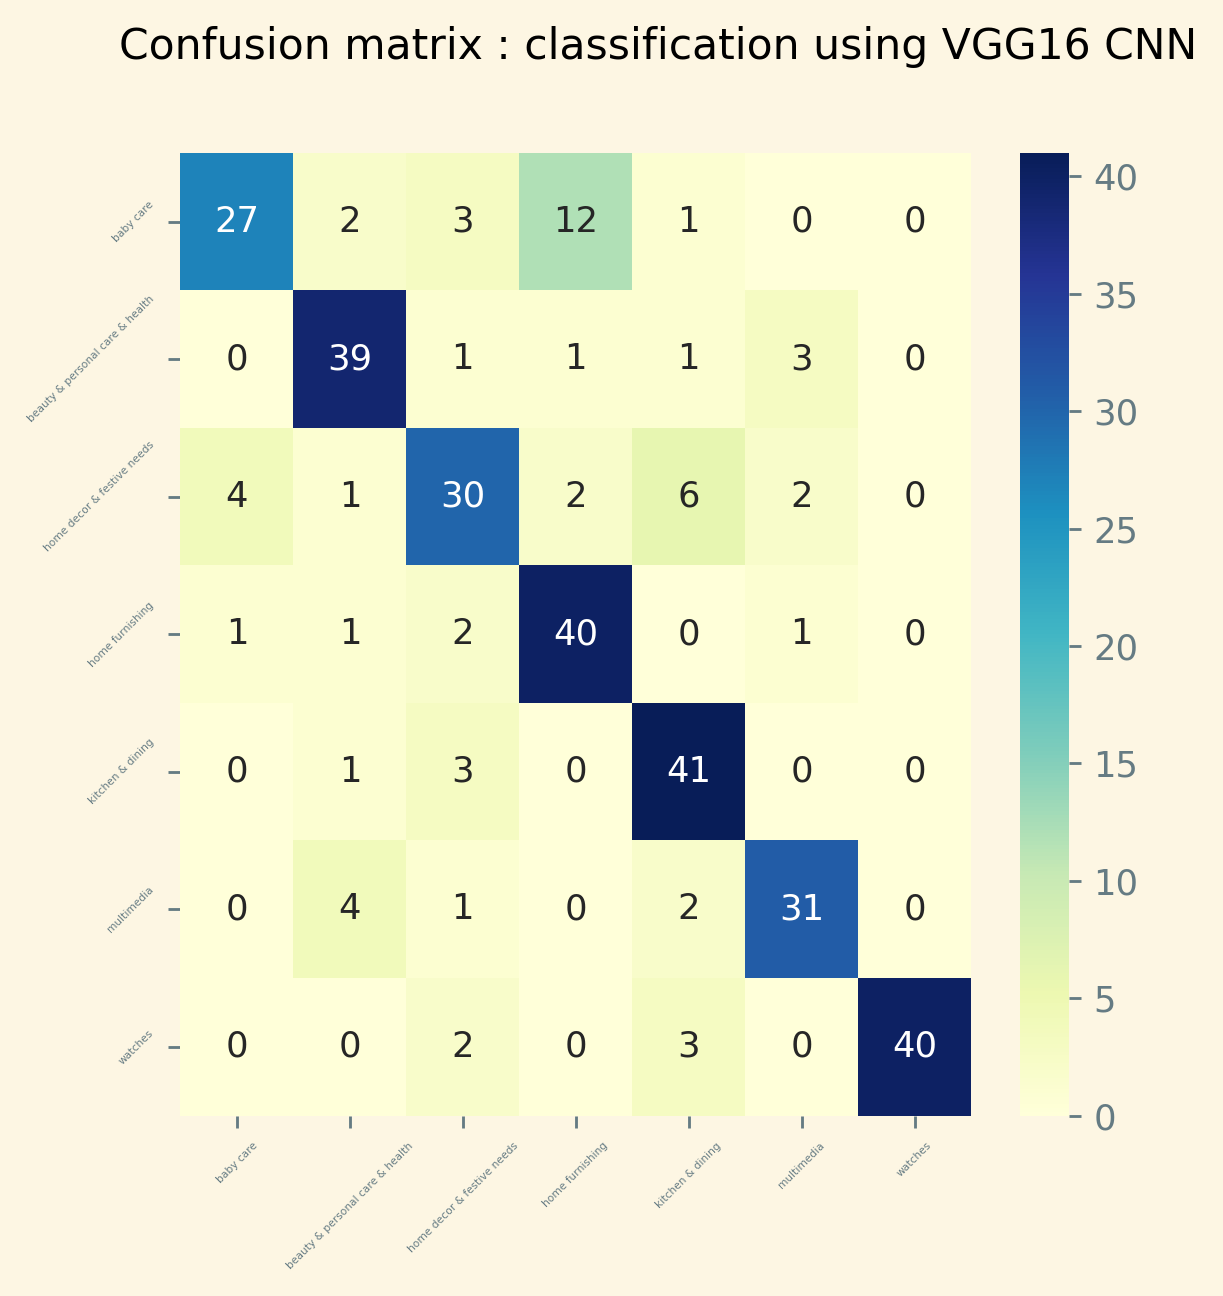

In [20]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(5, 5),
    dpi=255,
)

sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", xticklabels=True, yticklabels=True)

###
# Titles/Lables
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tick_params(labelsize=3)
fig.suptitle("Confusion matrix : classification using VGG16 CNN")
#
###

plt.show()


# Conclusion :

- VGG16 algorithm + fine tuning is promising but can be a bit innacurate on a few classes. The training set being around 700 items long, it can explain that lack of precision.
- Running the algorithm for less epochs, augmenting dropout, increasing batch size etc. might be good ways to avoid overfitting.
- If the access to the entire client's database is granted, it might be interesting to train a CNN from scratch specifically on this database (if the labels are all correct) to see if better results are achieved on a greater scale. It would be time consuming and tedious if the labels are not exact but that's a possibility as well.